In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf 

from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/combined_data.csv', index_col=0)
data.sample(3)

,text,sentiment
7,If you are Razr owner...you must have this!,1
1348,Sadly Gordon Ramsey's Steak is a place we shal...,0
450,i'm glad i found this product on amazon it is ...,1


In [3]:
sentences = data['text'].tolist()
labels = data['sentiment'].tolist()

In [4]:
vocab_size = 1000

In [5]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length = 5)

In [6]:
tokenizer.vocab_size

999

In [7]:
print(sentences[5])

I have to jiggle the plug to get it to line up right to get decent volume.


In [8]:
encoded = tokenizer.encode(sentences[5])
print(encoded)

[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [9]:
for en in encoded:
    print(tokenizer.decode([en]), en)

I  4
have  31
to  6
j 849
ig 162
gl 450
e  12
the  1
pl 600
ug 438
  775
to  6
get  175
it  14
to  6
li 55
ne  213
up  159
right 474
  775
to  6
get  175
dec 614
ent  380
vo 295
lu 148
me 72
. 789


## Replace sentence data with encoded subwords

In [10]:
for i ,sentence in enumerate(sentences):
    sentences[i] = tokenizer.encode(sentence)

In [11]:
sentences[1]

[625, 677, 626, 274, 380, 633, 148, 844, 789]

## Pre-Processing

In [12]:
max_length =50


In [13]:
# pad sequnces
pad_sequences = pad_sequences(sentences, maxlen=max_length, padding='post', truncating='post')

pad_sequences[1]

array([625, 677, 626, 274, 380, 633, 148, 844, 789,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Split into test and train data

In [14]:
split_index = int(len(pad_sequences)*0.8)

In [15]:
train_seq = pad_sequences[0: split_index]
test_seq = pad_sequences[split_index: ]

In [16]:
train_label = labels[0: split_index]
test_label = labels[split_index: ]

In [17]:
train_label = np.array(train_label)
test_label = np.array(test_label)

## Create Model Using Embedding

In [18]:
embedding_dim = 16

In [19]:
l0 = tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length)
l1 = tf.keras.layers.GlobalAveragePooling1D()
l2 = tf.keras.layers.Dense(units=6, activation ='relu')
l3 = tf.keras.layers.Dense(units =2, activation='softmax')

In [20]:
model = tf.keras.Sequential([l0, l1, l2, l3])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 14        
Total params: 16,116
Trainable params: 16,116
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
             metrics=['accuracy'], 
             optimizer='adam')

## Training

In [22]:
train_seq.shape, train_label.shape

((1593, 50), (1593,))

In [23]:
EPOCHS = 30
history = model.fit(train_seq, 
         train_label, 
         epochs=EPOCHS, 
         validation_data=(test_seq, test_label)           
         )

Epoch 1/30
50/50 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5217 - val_loss: 0.6987 - val_accuracy: 0.4110
Epoch 2/30
50/50 [==============================] - 0s 1ms/step - loss: 0.6882 - accuracy: 0.5223 - val_loss: 0.6971 - val_accuracy: 0.4110
Epoch 3/30
50/50 [==============================] - 0s 1ms/step - loss: 0.6834 - accuracy: 0.5392 - val_loss: 0.6975 - val_accuracy: 0.4361
Epoch 4/30
50/50 [==============================] - 0s 1ms/step - loss: 0.6751 - accuracy: 0.5631 - val_loss: 0.6879 - val_accuracy: 0.5063
Epoch 5/30
50/50 [==============================] - 0s 1ms/step - loss: 0.6604 - accuracy: 0.6397 - val_loss: 0.6744 - val_accuracy: 0.5363
Epoch 6/30
50/50 [==============================] - 0s 1ms/step - loss: 0.6368 - accuracy: 0.7288 - val_loss: 0.6589 - val_accuracy: 0.5840
Epoch 7/30
50/50 [==============================] - 0s 1ms/step - loss: 0.6044 - accuracy: 0.7615 - val_loss: 0.6261 - val_accuracy: 0.6967
Epoch 8/30
50/50 [==

## Plot Accuracy /Loss

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

x_rng = range(0, EPOCHS)

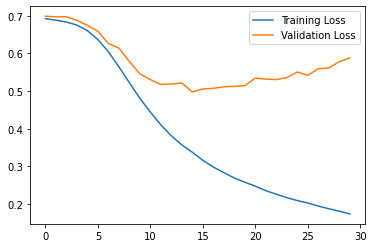

In [25]:
plt.plot(x_rng, loss, label ='Training Loss')
plt.plot(x_rng, val_loss, label ='Validation Loss')

plt.legend()
plt.show()

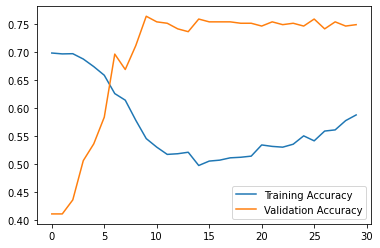

In [26]:
plt.plot(x_rng, acc, label ='Training Accuracy')
plt.plot(x_rng, val_accuracy, label ='Validation Accuracy')

plt.legend()
plt.show()

## Visualize the Network

In [27]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 16)


In [28]:
import io

# Write out the embedding vectors and metadata
out_v = io.open('vecs_sub.tsv', 'w', encoding='utf-8')
out_m = io.open('meta_sub.tsv', 'w', encoding='utf-8')

for word_num in range(0, vocab_size - 1):
    word = tokenizer.decode([word_num])
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()